In [10]:
from PaddleOCR.paddleocr import PaddleOCR
from PIL import ImageDraw, Image
import os, cv2, glob

from basicsr.utils import imwrite
# Paddleocr supports Chinese, English, French, German, Korean and Japanese.
# You can set the parameter `lang` as `ch`, `en`, `fr`, `german`, `korean`, `japan`
# to switch the language model in order.
ocr = PaddleOCR(ocr_version="PP-OCRv4",
                lang = 'en') # need to run only once to download and load model into memory

# ocr = PaddleOCR(ocr_version="PP-OCR", lang = 'en')

img_path = 'temp/temp_num/0/2528_3047_2669_3266.png'

img = Image.open(img_path)

result = ocr.ocr(img_path, det = True,  rec=False)
# for idx in range(len(result)):
#     res = result[idx]
#     for line in res:
#         print(line)
#         x1, y1 = line[0]
#         x2, y2 = line[2]
#         word = img.crop((x1, y1, x2, y2))
result

[2024/06/28 13:17:13] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, use_npu=False, use_mlu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='/home/bu0ai/.paddleocr/whl/det/en/en_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='/home/bu0ai/.paddleocr/whl/rec/en/en_PP-OCRv4_rec_infer', rec_image_inverse=True, rec_image_shape='3, 48, 320', rec_batch_num=6, max_text_leng

[[[[7.0, 2.0], [46.0, 2.0], [46.0, 52.0], [7.0, 52.0]]]]

In [8]:
float('2')

2.0

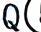

In [20]:
word

In [3]:
list_need_up = glob.glob('temp/temp_paddle_paddle/*')
model = RRDBNet(num_in_ch=3, num_out_ch=3, num_feat=64, num_block=23, num_grow_ch=32, scale=2)
bg_upsampler = RealESRGANer(
                            scale=2,
                            model_path='https://github.com/xinntao/Real-ESRGAN/releases/download/v0.2.1/RealESRGAN_x2plus.pth',
                            model=model,
                            tile=400,
                            tile_pad=10,
                            pre_pad=0,
                            half=True)
GFP_GAN_Model = GFPGANer(model_path='GFPGAN/experiments/pretrained_models/GFPGANv1.3.pth',
                                upscale=2,
                                arch='clean',
                                channel_multiplier=2,
                                bg_upsampler=bg_upsampler)
def upscale_image(image_path: str, restorer,is_saved: bool = True, des_path: str = ''):


    img_name = os.path.basename(image_path)
    # print(f'Processing {img_name} ...')
    basename, ext = os.path.splitext(img_name)
    input_img = cv2.imread(image_path, cv2.IMREAD_COLOR)

    # restore all component if necessary
    _, _, restored_img = restorer.enhance(
        input_img,
        has_aligned= False,
        only_center_face= False,
        paste_back= True,
        weight= 0.5)
    
    if restored_img is not None:
        if ext == 'auto':
            extension = 'jpg'
        else:
            extension = ext
        save_restore_path = os.path.join(f'{des_path}', f"{basename}{extension}")
        imwrite(restored_img, save_restore_path)

for image in list_need_up:
    upscale_image(image, GFP_GAN_Model, is_saved=True, des_path='temp/temp_save_core_restore')

In [2]:
import cv2
import numpy as np


img = cv2.imread('temp/temp_save_core_restore/663_2424_762_2528.png', cv2.IMREAD_COLOR) 
  
# Convert to grayscale. 
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) 
  
# Blur using 3 * 3 kernel. 
gray_blurred = cv2.blur(gray, (3, 3)) 
  
# Apply Hough transform on the blurred image. 
detected_circles = cv2.HoughCircles(gray_blurred,  
                   cv2.HOUGH_GRADIENT, 1, 20, param1 = 50, 
               param2 = 30, minRadius = 1, maxRadius = 40) 
  
# Draw circles that are detected. 
if detected_circles is not None: 
  
    # Convert the circle parameters a, b and r to integers. 
    detected_circles = np.uint16(np.around(detected_circles)) 
  
    for pt in detected_circles[0, :]: 
        a, b, r = pt[0], pt[1], pt[2] 
  
        # Draw the circumference of the circle. 
        cv2.circle(img, (a, b), r, (0, 255, 0), 2) 
  
        # Draw a small circle (of radius 1) to show the center. 
        cv2.circle(img, (a, b), 1, (0, 0, 255), 3) 


: 

In [7]:
import torch
from PIL import Image
from strhub.data.module import SceneTextDataModule

# Load model and image transforms
parseq = torch.hub.load('baudm/parseq', 'parseq_tiny', pretrained=True).eval()
img_transform = SceneTextDataModule.get_transform(parseq.hparams.img_size)

img = Image.open('temp/temp_num/0/737_2350_825_2418.png').convert('RGB')
# Preprocess. Model expects a batch of images with shape: (B, C, H, W)
img = img_transform(img).unsqueeze(0)

logits = parseq(img)
logits.shape  # torch.Size([1, 26, 95]), 94 characters + [EOS] symbol

# Greedy decoding
pred = logits.softmax(-1)
label, confidence = parseq.tokenizer.decode(pred)
print('Decoded label = {}'.format(label[0]))

Decoded label = 2


Using cache found in /home/bu0ai/.cache/torch/hub/baudm_parseq_main


In [13]:
%cd east_pytorch/
!python detect.py --weights weights/model.pt --input "/mnt/d/docker_volume/room_of_nhanhuynh/ai_butler/CAD-ShibaSangyo/full_build_from_scratch_nhanhuynh/temp/temp_char/0/592_2469_664_2562.png" --output "output.png"

[Errno 2] No such file or directory: 'east_pytorch/'
/mnt/d/docker_volume/room_of_nhanhuynh/ai_butler/CAD-ShibaSangyo/full_build_from_scratch_nhanhuynh/east_pytorch
